# Graph isomorphism networks

> " /ᐠ｡▿｡ᐟ\\*ᵖᵘʳʳ* Redes neuronales de grafos, la moda que se viene"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Matías Battocchia
- categories: [pytorch,grafos,paper]

Estas notas corresponden a la sección de código de una charla que di en el seminario [MachinLenin](https://twitter.com/machinlenin) en 2019. Esta es la [presentación](https://docs.google.com/presentation/d/1y9-4LMrm0UPqwYYBWwTMn-ixBazD8-nRnr6EIn53Nig/edit?usp=sharing) que usé y este el [repositorio](https://github.com/matiasbattocchia/gin).

Esta es una implementación simple, con fines didácticos y para nada eficiente de la publicación [How powerful are graph neural networks?](https://arxiv.org/pdf/1810.00826.pdf). Para una implementación eficiente ver [GINConv](https://docs.dgl.ai/api/python/nn.pytorch.html#ginconv) de Deep Graph Library (DGL).

La publicación mencionada fue la que elegí para comenzar a aprender sobre redes neuronales de grafos (*graph neural networks* o GNN). Unas redes interesantes porque no todo es texto, ni todo son imágenes, ni tablas... una vasta cantidad de información se representa en forma de grafo, y estas redes se especializan en esta estructura de datos.

## Publicaciones

Hoy en día si tuviese que recomendar lecturas introductorias, serían los *reviews* de esta lista.

**Reviews**

* [Benchmarking Graph Neural Networks](https://arxiv.org/pdf/2003.00982.pdf)
* [Representation Learning on Graphs: Methods and Applications](https://arxiv.org/abs/1709.05584) | http://snap.stanford.edu/proj/embeddings-www/

**Arquitecturas**

* [GAT](https://arxiv.org/pdf/1710.10903)
* [GIN](https://arxiv.org/pdf/1810.00826)
* [GCN](https://arxiv.org/abs/1609.02907)
* [GraphSAGE](https://arxiv.org/pdf/1706.02216.pdf)

In [2]:
import torch
import networkx as nx

%matplotlib inline

## Adjacency matrix

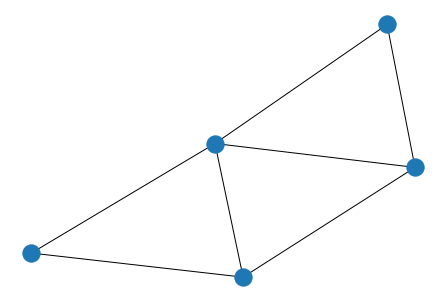

In [4]:
G = nx.binomial_graph(5,0.5)

# TODO: numerar los nodos en el gráfico
nx.draw(G)

In [5]:
A = torch.tensor( nx.adjacency_matrix(G).todense(), dtype=torch.float32 )

A

tensor([[0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1.],
        [1., 0., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [0., 1., 1., 1., 0.]])

In [6]:
X = torch.randint(low=0, high=2, size=(5,2), dtype=torch.float32)

X

tensor([[0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.]])

In [7]:
A @ X

tensor([[1., 0.],
        [0., 0.],
        [0., 1.],
        [1., 1.],
        [1., 0.]])

## Dataset

In [51]:
import torch.utils.data

import importlib  
gnns = importlib.import_module('powerful-gnns.util')

class GraphDataset(torch.utils.data.Dataset):
    """ Levanta los datasets de Powerful-GNNS. """
    
    def __init__(self, dataset, degree_as_tag=False):
        self.data, self.classes = gnns.load_data(dataset, degree_as_tag)
        
        self.features = self.data[0].node_features.shape[1]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        graph = self.data[idx]
        adjacency_matrix = nx.adjacency_matrix( graph.g ).todense()
        
        item = {}

        item['adjacency_matrix'] = torch.tensor(adjacency_matrix, dtype=torch.float32)
        item['node_features'] = graph.node_features
        item['label'] = graph.label
        
        return item

In [52]:
DS = GraphDataset('PROTEINS')

loading data
# classes: 2
# maximum node tag: 3
# data: 1113


In [41]:
DL = torch.utils.data.DataLoader(DS)

## Net modules

In [66]:
class GINConv(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        
        self.linear = torch.nn.Linear(hidden_dim, hidden_dim)

    def forward(self, A, X):
        """
        Params
        ------
        A [batch x nodes x nodes]: adjacency matrix
        X [batch x nodes x features]: node features matrix
        
        Returns
        -------
        X' [batch x nodes x features]: updated node features matrix
        """
        X = self.linear(X + A @ X)
        X = torch.nn.functional.relu(X)
        
        return X

In [73]:
class GNN(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super().__init__()
        
        self.in_proj = torch.nn.Linear(input_dim, hidden_dim)
        
        self.convs = torch.nn.ModuleList()
        
        for _ in range(n_layers):
            self.convs.append(GINConv(hidden_dim))
        
        # In order to perform graph classification, each hidden state
        # [batch x nodes x hidden_dim] is concatenated, resulting in
        # [batch x nodes x hiddem_dim*(1+n_layers)], then aggregated
        # along nodes dimension, without keeping that dimension:
        # [batch x hiddem_dim*(1+n_layers)].
        self.out_proj = torch.nn.Linear(hidden_dim*(1+n_layers), output_dim)

    def forward(self, A, X):
        X = self.in_proj(X)

        hidden_states = [X]
        
        for layer in self.convs:
            X = layer(A, X)
            hidden_states.append(X)

        X = torch.cat(hidden_states, dim=2).sum(dim=1)

        X = self.out_proj(X)

        return X

## Train loop

In [77]:
model = GNN(input_dim=DS.features, hidden_dim=3, output_dim=DS.classes, n_layers=3)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 5

for epoch in range(EPOCHS):
    running_loss = 0.0
    
    for i, batch in enumerate(DL):
        A = batch['adjacency_matrix']
        X = batch['node_features']
        labels = batch['label']
                
        optimizer.zero_grad()

        outputs = model(A, X)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'{epoch} - loss: {running_loss/(i+1)}')

0 - loss: 1.2691171061103663
1 - loss: 0.32851389047806046
2 - loss: 0.944981049655904
3 - loss: 0.2894633889519622
4 - loss: 0.3056941165221455


## TODO

* Dropout
* Mini-batches (`collate_fn` for padding)
* Batch normalization

* Extended neighborhood `X = self.linear(X + A @ X + A**2 @ X)`
* Node classification
* Link prediction